In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from moviepy.editor import VideoFileClip, clips_array
import os
os.environ["DLClight"] = "True"
from deeplabcut.utils import auxiliaryfunctions
from deepgraphpose.utils_model import get_train_config
import sys

from deepgraphpose.models.fitdgp_util import get_snapshot_path
from moviepy.editor import VideoFileClip
from deepgraphpose.models.eval import setup_dgp_eval_graph, export_pose_like_dlc

DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


In [2]:
def estimate_pose(proj_cfg_file, dgp_model_file, video_file, output_dir, shuffle=1,
        save_pose=True, save_str='', new_size=None, save_heatmap=False):
    import yaml
    from tqdm import tqdm
    from skimage import img_as_ubyte
    """Estimate pose on an arbitrary video.

    Parameters
    ----------
    proj_cfg_file : str, optional
        dlc project config file (.yaml) (if `label_dir` is None)
    dgp_model_file : str, optional
        dgp model weights; .ckpt if fitting full resnet, .npy if only fitting final conv layer
    video_file : str
        video to label
    output_dir : str
        output directory to store labeled video
    shuffle : int, optional
        dlc shuffle number
    save_pose : bool, optional
        True to save out pose in csv/hdf5 file
    save_str : str, optional
        additional string to append to labeled video file name

    Returns
    -------
    dict

    """
    from deepgraphpose.utils_model import get_train_config

    f = os.path.basename(video_file).rsplit('.', 1)
    save_file = os.path.join(output_dir, f[0] + '_labeled%s' % save_str)
    if os.path.exists(save_file + '.csv'):
        print('labels already exist! video at %s will not be processed' % video_file)
       
        if save_heatmap:
            if os.path.exists(save_file + '.npy'):
                print('heatmap already exist! video at %s will not be processed' % video_file)
                return save_file + '.csv'
            else:
                print('Processing for heatmap, will overwrite label files\n\n')
        else:
            return
    
    # -------------------
    # loading
    # -------------------
    # load video
    print('initializing video clip...', end='')
    video_clip = VideoFileClip(str(video_file))
    n_frames = np.ceil(video_clip.fps * video_clip.duration).astype('int')
    print('done')

    # load dlc project config file
    print('loading dlc project config...', end='')
    with open(proj_cfg_file, 'r') as stream:
        proj_config = yaml.safe_load(stream)
    proj_config['video_path'] = None
    dlc_cfg = get_train_config(proj_config, shuffle=shuffle)
    print('done')

    # -------------------
    # extract pose
    # -------------------
    try:
        dlc_cfg.net_type = 'resnet_50'
        sess, mu_n, _, scmap, _, inputs = setup_dgp_eval_graph(dlc_cfg, dgp_model_file)
    except:
        dlc_cfg.net_type = 'resnet_101'
        sess, mu_n, _, scmap, _, inputs = setup_dgp_eval_graph(dlc_cfg, dgp_model_file)

    print('\n')
    """
    pbar = tqdm(total=n_frames, desc='processing video frames')
    markers = np.zeros((n_frames, dlc_cfg.num_joints, 2))
    likelihoods = np.zeros((n_frames, dlc_cfg.num_joints))
    for i, frame in enumerate(video_clip.iter_frames()):
        # get resnet output
        ff = img_as_ubyte(frame)
        mu_n_batch = sess.run(mu_n, feed_dict={inputs: ff[None, :, :, :]})
        markers[i] = mu_n_batch * dlc_cfg.stride + 0.5 * dlc_cfg.stride
        likelihoods[i] = 0.5

        pbar.update(1)
    """
    #%%
    nj = dlc_cfg.num_joints
    nx, ny = video_clip.size
    nx_out, ny_out = int((nx - dlc_cfg.stride/2)/dlc_cfg.stride  + 1) + 5, int((ny -
                                                                       dlc_cfg.stride/2)/dlc_cfg.stride  + 1) + 5
    #%%
    markers = np.zeros((n_frames + 1, dlc_cfg.num_joints, 2))
    softmaxtensors = np.zeros((n_frames + 1, ny_out, nx_out, nj))
    pbar = tqdm(total=n_frames, desc='processing video frames')
    for ii, frame in enumerate(video_clip.iter_frames()):
        if new_size is not None:
            frame = Image.fromarray(frame)
            scale_x = frame.width / new_size[1]
            scale_y = frame.height / new_size[0]
            # width, height
            frame = frame.resize(size=(new_size[1], new_size[0]))
            frame = np.asarray(frame)
        else:
            scale_x = 1
            scale_y = 1
        ff = img_as_ubyte(frame)

        mu_n_batch, scmap_np = sess.run([mu_n, scmap],
                                                 feed_dict={inputs: ff[None, :, :, :]})
        markers[ii] = mu_n_batch[0]
        softmaxtensors[ii,:int(scmap_np[0].shape[0]),:int(scmap_np[0].shape[1])] = scmap_np[0]
        pbar.update(1)
    
    n_frames = ii +1
    pbar.close()
    sess.close()
    video_clip.close()
    markers = markers[:n_frames]
    softmaxtensors=softmaxtensors[:n_frames]
    
    softmaxtensors = softmaxtensors[:,:int(scmap_np[0].shape[0]),:int(scmap_np[0].shape[1])]
    #%%
    xr = markers[:, :, 1] * dlc_cfg.stride + 0.5 * dlc_cfg.stride # T x nj
    yr = markers[:, :, 0] * dlc_cfg.stride + 0.5 * dlc_cfg.stride
    #%%
    # true xr
    xr *= scale_x
    yr *= scale_y
    print('Finished collecting markers')
    n_frames = xr.shape[0]
    #%%
    print('Calculate likelihoods')
    sigmoid_pred_np = np.exp(softmaxtensors) / (np.exp(softmaxtensors) + 1)
    mu_likelihoods = np.zeros((n_frames, nj, 2)).astype('int')
    likelihoods = np.zeros((n_frames, nj))
    offset_mu_jj = 0
    
    for ff_idx in range(n_frames):
        for jj_idx in range(nj):
            mu_jj = markers[ff_idx, jj_idx]
            ends_floor = np.floor(mu_jj).astype('int') - offset_mu_jj
            ends_ceil = np.ceil(mu_jj).astype('int') + 1 + offset_mu_jj
            sigmoid_pred_np_jj = sigmoid_pred_np[ff_idx, :, :, jj_idx]
            spred_centered = sigmoid_pred_np_jj[ends_floor[0]:ends_ceil[0],
                             ends_floor[
                                 1]:ends_ceil[1]]
            mu_likelihoods[ff_idx, jj_idx] = np.unravel_index(
                np.argmax(spred_centered),
                spred_centered.shape)
            mu_likelihoods[ff_idx, jj_idx] += [ends_floor[0], ends_floor[1]]
            likelihoods[ff_idx, jj_idx] = sigmoid_pred_np_jj[
                int(mu_likelihoods[ff_idx,
                                   jj_idx][0]),
                int(mu_likelihoods[ff_idx,
                                   jj_idx][1])
            ]
    print('Storing data')

    # -------------------
    # save labels
    # -------------------
    labels = {'x': xr, 'y': yr, 'likelihoods': likelihoods}

    # convert to DLC-like csv/hdf5
    if save_pose:
        if not Path(save_file).parent.exists():
            os.makedirs(os.path.dirname(save_file))
        export_pose_like_dlc(labels, os.path.basename(dgp_model_file),
            dlc_cfg.all_joints_names, save_file)
        
    if save_heatmap:
        labels['heatmap']= softmaxtensors
        labels['heatmap_mu'] = markers
        save_file2 = save_file +'.npy'
        print('Stored heatmap in {}'.format(save_file2))
        np.save(save_file, labels)
    return labels

def load_pose_from_dlc_to_dict(filename):
    from numpy import genfromtxt
    dlc = genfromtxt(filename, delimiter=',', dtype=None, encoding=None)
    dlc = dlc[3:, 1:].astype('float')  # get rid of headers, etc.
    labels = {
        'x': dlc[:, 0::3],
        'y': dlc[:, 1::3],
        'likelihoods': dlc[:, 2::3]}
    return labels


In [3]:
def get_frames(xr, yr, train_frames):
    return xr[train_frames, :] , yr[train_frames, : ]

def marker_epsilon_distance(xr, yr, xr1, yr1, epsilon=0):
    # euclidean distance
    # RMSE root mean sqaured error
    # calculate distance
    dx = (xr - xr1)**2 # T x D
    dy = (yr - yr1)**2 # T x D
    dxy = dx + dy
    indiv_dist = np.sqrt(dxy) # T x D
    # epsilon for distance

    indiv_dist_epsilon = indiv_dist < epsilon
    indiv_dist[indiv_dist_epsilon] = 0
    indiv_dist2 = indiv_dist**2
    indiv_dist2 = indiv_dist2.sum(-1)
    num_points = np.prod(indiv_dist2.shape)
    dist = np.sqrt(indiv_dist2.sum()/num_points)
    #dist = np.sqrt(indiv_dist2)
    return dist  # T

def calculate_rmse_frames(xr, yr, xr1, yr1, train_frames,epsilon=0):
    # xr  T x D
    # xrt : x1 (len(train_frames) x D
    # xr1 T x D
    xrt, yrt = get_frames(xr, yr, train_frames)
    xr1t, yr1t = get_frames(xr1, yr1, train_frames)
    return marker_epsilon_distance(xrt, yrt, xr1t, yr1t,epsilon=epsilon) # D
#%%

In [4]:

# Read true_data

import scipy.io as sio
true_data = '/share/ctn/users/ekb2154/data/libraries/dgp_paninski/etc/train_sample_ablation/ibl1_true_xy_all_918pm.mat'
data_true = sio.loadmat(str(true_data))
xr_true = data_true['true_xy'][:,:,0].T
yr_true = data_true['true_xy'][:,:,1].T
xrlabeled = xr_true[:,[1,3,0, 2]] # T x D
yrlabeled = yr_true[:,[1,3,0, 2]] # T x D

In [5]:
# read names for models 
num_trains = 5
num_seeds = 6#19
training_subsets = np.round(np.linspace(0.1,0.9, num_trains), 2)
training_seed = np.arange(1, num_seeds+1).astype('int')

# only error is for seed 2 in tindex 1
date_names = []
for tindex, tseed in product(*(range(1, num_trains+1), range(1, num_seeds+1))):
    date_name = "2050-{:02d}-{:02d}".format(tindex, tseed)
    print(date_name)

2050-01-01
2050-01-02
2050-01-03
2050-01-04
2050-01-05
2050-01-06
2050-02-01
2050-02-02
2050-02-03
2050-02-04
2050-02-05
2050-02-06
2050-03-01
2050-03-02
2050-03-03
2050-03-04
2050-03-05
2050-03-06
2050-04-01
2050-04-02
2050-04-03
2050-04-04
2050-04-05
2050-04-06
2050-05-01
2050-05-02
2050-05-03
2050-05-04
2050-05-05
2050-05-06


In [6]:
def get_mu_smooth(ref_):
    import tensorflow as tf

    vers = tf.__version__.split('.')
    if int(vers[0]) == 1 and int(vers[1]) > 12:
        TF = tf.compat.v1
    else:
        TF = tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    # now pass this vector through the
    from deepgraphpose.models.fitdgp_util import argmax_2d_from_cm, dgp_prediction_layer
    n_frames, _ ,_ , nj = ref_.shape

    TF.reset_default_graph()
    gamma = 1
    gauss_len=1
    scmap2 = TF.placeholder(tf.float32, shape=[1, None, None, nj])
    mu_n, softmax_tensor = argmax_2d_from_cm(scmap2, dlc_cfg.num_joints, gamma, gauss_len)
    # initialize tf session
    config_TF = TF.ConfigProto()
    config_TF.gpu_options.allow_growth = True
    sess = TF.Session(config=config_TF)
    # initialize weights
    sess.run(TF.global_variables_initializer())
    sess.run(TF.local_variables_initializer())
    # for each frame for each 
    ref_x = np.zeros((n_frames,nj))*np.nan
    ref_y = np.zeros((n_frames,nj))*np.nan
    st_tensors = []
    for nt0 in range(n_frames):
        ff = ref_[nt0,:,:,:]
        #mu_n_np,st_tensor = sess.run(mu_n, feed_dict={scmap2: ff[None, :, :, :]})
        mu_n_np,st_tensor = sess.run([mu_n, softmax_tensor],feed_dict={scmap2: ff[None, :, :, :]})

        ref_y[nt0,:]=mu_n_np[0,:,0]
        ref_x[nt0,:]= mu_n_np[0,:,1]
        st_tensors.append(st_tensor[0])
    #ref_x = ref_x* dlc_cfg.stride + 0.5 * dlc_cfg.stride
    #ref_y = ref_y* dlc_cfg.stride + 0.5 * dlc_cfg.stride
    sess.close()
    # 
    # st_tensors_0
    st_tensors = np.stack(st_tensors)
    return ref_x, ref_y, st_tensors


def compare_ensemble_output(scmaps, method=1):
    # USE sigmoid
    if method ==30: # mean
        softmax_tensors = []
        for scmap_ in scmaps:
            st_tensors = np.exp(scmap_)/(np.exp(scmap_)+1)
            softmax_tensors.append(st_tensors)
        # pick highest ll
        
        ref_2 = np.mean(softmax_tensors,0)    
        # take inverse 
        ref_ = np.log(ref_2)- np.log(1-ref_2)
        ref_x, ref_y, st_tensors = get_mu_smooth(ref_)

    else:
        raise Exception('Not here')
    return ref_, ref_x, ref_y

def get_mu_fix(ref_, smooth=True):
    #original thing
    n_frames, d1,d2, nj = ref_.shape
    
    alpha = make2dgrid_np(ref_[0,:,:,0])
    if smooth:
        ref_y2, ref_x2 = (np.sum(alpha[:,:,:,None,None]*np.transpose(ref_,(1,2,0,3)),(1,2))/np.asarray([d2,d1])[:,None,None])
    else:
        ref_x2 = np.zeros((n_frames, nj))*np.nan#np.empty_like(xr)
        ref_y2 =  np.zeros((n_frames, nj))*np.nan#np.empty_like(yr)

        for nt0 in range(n_frames):
            for njj0 in range(nj):
                ref_y2[nt0,njj0], ref_x2[nt0,njj0] = np.unravel_index(np.argmax(ref_[nt0,:,:,njj0]), ref_.shape[1:3])
    
    return ref_x2, ref_y2

def make2dgrid_np(ref_c):
    d1, d2 = ref_c.shape
    x_i = np.arange(d1)*d2
    y_i = np.arange(d2)*d1
    xg, yg = np.meshgrid(x_i, y_i)
    alpha = np.array([xg, yg]).swapaxes(1, 2)  # 2 x nx_out x ny_out
    return alpha

def calculate_ensemble_output(heatmaps_files, dlc_cfg, snapshot, moviefile, method, n_frames=1000):
    """
    reads heatmaps from .npy files and calculates the ensemble trace
    Parameters
    ----------
    heatmaps_files
    dlc_cfg
    Returns
    -------
    """
    scmaps =[]
    for heatmaps_file in heatmaps_files:
        labels = np.load(heatmaps_file, allow_pickle=True)[()]
        softmaxtensor = labels['heatmap']
        #softmaxtensor_ = np.exp(softmaxtensor)/np.exp(softmaxtensor).sum()
        #_, _, _, _, _, softmaxtensor, _ = get_body(heatmaps_file, snapshot, moviefile, n_frames)
        scmaps.append(softmaxtensor)

    # scmap -> smooth -> softmax -> softargmax
    _, ref_x, ref_y = compare_ensemble_output(scmaps, method=method)
    
    ref_x = ref_x* dlc_cfg.stride + 0.5 * dlc_cfg.stride
    ref_y = ref_y* dlc_cfg.stride + 0.5 * dlc_cfg.stride
    return ref_x, ref_y  

def get_body(dlcpath, snapshot, moviefile, n_frames):
    print('Collecting markers from snapshot')
    print(snapshot)
    print('\n')
    video_clip = VideoFileClip(str(moviefile))
    fps = video_clip.fps
    n_frames2 = min(n_frames + 1, np.ceil(video_clip.fps * video_clip.duration).astype('int'))
    offset= 0
    video_clip = video_clip.subclip(offset, offset+(n_frames2 / fps))

    snapshot_path, cfg_yaml = get_snapshot_path(snapshot, dlcpath, shuffle=shuffle)
    cfg = auxiliaryfunctions.read_config(cfg_yaml)

    # %%
    proj_cfg_file = str(cfg_yaml)
    dgp_model_file = str(snapshot_path)
    # %% estimate_pose
    # load dlc project config file
    print('loading dlc project config...')
    with open(proj_cfg_file, 'r') as stream:
        proj_config = yaml.safe_load(stream)
    proj_config['video_path'] = None
    dlc_cfg = get_train_config(proj_config, shuffle=shuffle)
    print('done')
    # %%
    try:
        dlc_cfg.net_type = 'resnet_50'
        sess, mu_n, softmax_tensor, scmap, locref, inputs = setup_dgp_eval_graph(dlc_cfg,
                                                                                 dgp_model_file)
    except:
        dlc_cfg.net_type = 'resnet_101'
        sess, mu_n, softmax_tensor, scmap, locref, inputs = setup_dgp_eval_graph(dlc_cfg,
                                                                                 dgp_model_file)
    # %%
    nj = dlc_cfg.num_joints
    bodyparts = cfg['bodyparts']
    # %%
    nx, ny = video_clip.size
    nx_out, ny_out = int((nx - dlc_cfg.stride/2)/dlc_cfg.stride  + 5), int((ny - dlc_cfg.stride/2)/dlc_cfg.stride  + 5)
    #%%
    markers = np.zeros((n_frames2 + 1, dlc_cfg.num_joints, 2))
    likes = np.zeros((n_frames2 + 1, dlc_cfg.num_joints))
    softmaxtensor = np.zeros((n_frames2 + 1, ny_out, nx_out, dlc_cfg.num_joints))
    pbar = tqdm(total=n_frames2, desc='processing video frames')
    for ii, frame in enumerate(video_clip.iter_frames()):
        ff = img_as_ubyte(frame)
        mu_n_batch, pred_np1 = sess.run( [mu_n,  scmap], feed_dict={inputs: ff[None, :, :, :]})
        nx_out_true, ny_out_true, _ = pred_np1[0].shape
        markers[ii] = mu_n_batch[0]
        num_frames = mu_n_batch.shape[0]  # nb #+ 1
        sigmoid_pred_np = np.exp(pred_np1) / (np.exp(pred_np1) + 1)        
        #softmaxtensor[ii][:nx_out_true,:ny_out_true] = sigmoid_pred_np[0]
        softmaxtensor[ii][:nx_out_true,:ny_out_true] = pred_np1[0]
        mu_likelihoods = np.zeros((num_frames, nj, 2)).astype('int')
        likelihoods = np.zeros((num_frames, nj))
        offset_mu_jj = 0
        for ff_idx in range(num_frames):
            for jj_idx in range(nj):
                # continuous so pick max in
                mu_jj = mu_n_batch[ff_idx, jj_idx]
                ends_floor = np.floor(mu_jj).astype('int') - offset_mu_jj
                ends_ceil = np.ceil(mu_jj).astype('int') + 1 + offset_mu_jj
                sigmoid_pred_np_jj = sigmoid_pred_np[ff_idx, :, :, jj_idx]
                spred_centered = sigmoid_pred_np_jj[ ends_floor[0]: ends_ceil[0],
                                 ends_floor[1]: ends_ceil[1]]
                mu_likelihoods[ff_idx, jj_idx] = np.unravel_index(
                    np.argmax(spred_centered), spred_centered.shape)
                mu_likelihoods[ff_idx, jj_idx] += [ends_floor[0], ends_floor[1]]
                likelihoods[ff_idx, jj_idx] = sigmoid_pred_np_jj[
                    int(mu_likelihoods[ff_idx, jj_idx][0]), int(mu_likelihoods[ff_idx, jj_idx][1])]
        likes[ii] = likelihoods[0]
        pbar.update(1)

    likes = likes[:ii+1]
    markers = markers[:ii+1]
    softmaxtensor = softmaxtensor[:ii+1,:nx_out_true,:ny_out_true,:]
    pbar.close()
    sess.close()
    video_clip.close()
    print('Finished collecting markers')
    print('\n')
    xx = markers[:, :, 1] * dlc_cfg.stride + 0.5 * dlc_cfg.stride
    yy = markers[:, :, 0] * dlc_cfg.stride + 0.5 * dlc_cfg.stride

    return xx, yy, likes, nj, bodyparts, softmaxtensor, dlc_cfg

method = 30

In [7]:
#%%
train_error_dgp = np.zeros((num_trains, num_seeds))*np.nan
test_error_dgp = np.zeros((num_trains, num_seeds))*np.nan

train_error_ensemble = np.zeros((num_trains,))*np.nan
test_error_ensemble = np.zeros((num_trains,))*np.nan

epsilon = 0

#%%
task="ibl1"
scorer="kelly"
data_directory = "/share/ctn/users/ekb2154/data/datasets/tracki/{0}/model_data/{0}-{1}".format(task,scorer)
video_folder = ""
traces_folder = "videos_pred/{}_labeledsnapshot-step2-final--0.csv".format(task)
heatmaps_folder = "videos_pred/{}_labeledsnapshot-step2-final--0.npy".format(task)
shuffle=1
trainingsetindex=0

#%%
train_indices = [[]]*num_trains
test_indices = [[]]*num_trains
heatmap_indices = [[]]*num_trains
skipped_seed = [[]]*num_trains
for date_idx, train_fraction in enumerate(training_subsets):
    print("\n\n{}".format(train_fraction))
    heatmaps_files = []
    train_frames_ensemble = []
    test_frames_ensemble = []
    for seed_idx, seed in enumerate(training_seed):
        date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}-{}".format(data_directory, date))
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            skipped_seed[date_idx].append(seed_idx)
            continue
        # ------
        # get train/test sets (indices for video)
        trainingsetfolder = auxiliaryfunctions.GetTrainingSetFolder(cfg)
        datafn, metadatafn = auxiliaryfunctions.GetDataandMetaDataFilenames(
            trainingsetfolder, cfg['TrainingFraction'][trainingsetindex], shuffle, cfg)
        
        # Load meta data
        data, trainIndices, testIndices, trainFraction = auxiliaryfunctions.LoadMetadata(
            os.path.join(cfg['project_path'], metadatafn))
        # the train indices are of the training set, so read the indices of the video
        Data = pd.read_hdf(os.path.join(cfg["project_path"], str(trainingsetfolder),
                                        'CollectedData_' + cfg["scorer"] + '.h5'),
                           'df_with_missing') #* dlc_cfg['global_scale']
        num_labels, _ = Data.values.shape
        labeled_frames = np.empty(num_labels).astype('int')
        for frame_idx in range(num_labels):
            idx_name = int(Path(Data.iloc[frame_idx].name).stem[3:])
            labeled_frames[frame_idx] = idx_name

        # Video frames user for training and testing:
        train_frames = labeled_frames[trainIndices]
        test_frames = labeled_frames[testIndices]

        # --- store confidence map to then calculate ensemble from heatmaps
        #last_snapshot, snapshot_data = get_last_snapshot(cfg_folder)
        #assert "step2-final"  in last_snapshot
        snapshot='snapshot-step2-final--0'
        print(cfg_folder.rsplit("/", 1)[-1], snapshot)
        # continue
        snapshot_path, cfg_yaml = get_snapshot_path(snapshot, cfg_folder,
                                                    shuffle=shuffle)
        #cfg = auxiliaryfunctions.read_config(cfg_yaml)
        video_file = Path(cfg_folder) / "videos/{}.mp4".format(task)
        video_pred_path = str(Path(cfg_folder) / 'videos_pred')
        print(snapshot_path)
        
        _ = estimate_pose(
                 proj_cfg_file=str(cfg_yaml),
                 dgp_model_file=str(snapshot_path),
                 video_file=str(video_file),
                 output_dir=str(video_pred_path),
                 shuffle=shuffle,
                 save_str=snapshot,
                 save_heatmap=True)
                
        heatmap_file = str(Path(cfg_folder)/ heatmaps_folder)
        heatmaps_files.append(heatmap_file)
        train_frames_ensemble.append(train_frames)
        test_frames_ensemble.append(test_frames)

    # calculate ensemble loss using the heatmaps stored in npy labeled folder
    video_sets = list(cfg['video_sets'].keys())
    video_name = video_sets[0]
    cfg['video_path']=  Path(cfg['project_path']) / video_name
    dlc_cfg = get_train_config(cfg, shuffle=shuffle)
    # train and test frames to use for ensemble
    train_indices[date_idx] = train_frames_ensemble
    test_indices[date_idx] = test_frames_ensemble 
    heatmap_indices[date_idx] = heatmaps_files
#%%
# we are going to use a different set of test indices which are not in the training set
train_frames = np.unique(np.concatenate([np.concatenate(t_) for t_ in train_indices]))
test_frames = np.setdiff1d(np.arange(1000),train_frames).astype('int')

#%%
for date_idx, train_fraction in enumerate([training_subsets][0]):
    #"""
    heatmaps_files = heatmap_indices[date_idx]
    xr_ensemble, yr_ensemble = calculate_ensemble_output(heatmaps_files, dlc_cfg, snapshot, video_file, method=method)
    train_error_ensemble[date_idx] = calculate_rmse_frames(xrlabeled, yrlabeled,
                                                                xr_ensemble, yr_ensemble,
                                                                train_frames,
                                                                epsilon=epsilon)

    test_error_ensemble[date_idx] = calculate_rmse_frames(xrlabeled, yrlabeled,
                                                                xr_ensemble, yr_ensemble,
                                                                test_frames,
                                                                epsilon=epsilon)
    #"""
    for seed_idx, seed in enumerate(training_seed):
        if seed_idx in skipped_seed[date_idx]:
            continue
        date = "2050-{:02d}-{:02d}".format(date_idx + 1, seed)
        cfg_folder = str(Path(data_directory)/ "{}-{}".format(data_directory, date))
        # read cfg file
        cfg_yaml = str(Path(cfg_folder)/ "config.yaml")
        cfg = auxiliaryfunctions.read_config(cfg_yaml)
        # read traces
        label_file = str(Path(cfg_folder)/ traces_folder)
        print(label_file)
        try:
            labels = load_pose_from_dlc_to_dict(label_file)
            xr_dgp = labels['x'] # T x D
            yr_dgp = labels['y']
        except:
            raise Exception("Not done")
        # calculate rmse
        train_error_dgp[date_idx, seed_idx] = calculate_rmse_frames(xrlabeled, yrlabeled, xr_dgp, yr_dgp, train_frames, epsilon=epsilon)
        test_error_dgp[date_idx, seed_idx] = calculate_rmse_frames(xrlabeled, yrlabeled, xr_dgp, yr_dgp, test_frames, epsilon=epsilon)
#%%



0.1
/share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-01/videos_pred/ibl1_labeledsnapshot-step2-final--0.csv
ibl1-kelly-2050-01-01 snapshot-step2-final--0
/share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-01/dlc-models/iteration-0/ibl1Jan1-trainset10shuffle1/train/snapshot-step2-final--0
labels already exist! video at /share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-01/videos/ibl1.mp4 will not be processed
heatmap already exist! video at /share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-01/videos/ibl1.mp4 will not be processed
/share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-02/videos_pred/ibl1_labeledsnapshot-step2-final--0.csv
ibl1-kelly-2050-01-02 snapshot-step2-final--0
/share/ctn/users/ekb2154/data/datasets/tracki/ibl1/model_data/ibl1-kelly-2050-01-02/dlc-models/iteration-0/ibl1Jan2-trainset10shuffle1/train/snapshot-step2-fi

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
xlabels = ['{}%'.format(int(ii*100)) for ii in training_subsets]

Text(0, 0.5, 'RMSE')

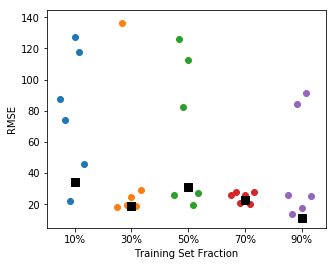

In [9]:
test_dgp_mean = np.nanmean(test_error_dgp, 1)
test_dgp_serr = np.nanstd(test_error_dgp, 1)

# make a scatter plot 
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
for ii in range(num_trains):
    dcmap = test_error_dgp[ii,:]
    dcmap = np.sort(dcmap)[::-1]
    new_ = (np.arange(num_seeds)-num_seeds//2)/num_seeds
    np.random.shuffle(new_)
    ax.scatter(ii+new_*0.5, dcmap)
    ax.plot(ii, test_error_ensemble[ii],'ks', markersize=8)#, alpha=0.5,marker='o')

ax.set_xticks(range(len(test_dgp_mean)))
ax.set_xticklabels(xlabels)
ax.set_xlabel("Training Set Fraction")
ax.set_ylabel("RMSE")

In [10]:
# Check overlap between runs:

In [11]:
np.stack(train_indices[0]).shape

(6, 5)

In [12]:
# Here there are 5 splits
print(len(train_indices))
train_splits = []
# make sure that all splits are the same
for ii in range(len(train_indices)):
    d_ = np.stack(train_indices[ii]) # seed x n_splits
    #assert np.all(np.unique(d_) == d_[0])
    train_splits.append(np.unique(d_))


5


In [13]:
# print splits to make sure that all the splits are inclusive
ministack = []
for ii in range(len(train_indices)-1):
    if ii == 0:
        # init bucket
        ministack += list(train_splits[ii])
        print('stack 0 ', ministack)
        continue
    # check for elements not in bucket
    assert len(np.intersect1d(train_splits[ii-1], ministack)) == len(ministack)
    new_split = np.setdiff1d(train_splits[ii], ministack)
    print('stack {},{}'.format(ii, new_split))
    # add elements to bucket
    ministack += list(new_split)    

stack 0  [0, 14, 25, 31, 38, 271, 291, 297, 311, 338, 354, 381, 382, 415, 439, 486, 512, 541, 580, 683, 693, 778, 925, 933, 953, 978]
stack 1,[  6  10  43 258 314 328 339 345 350 406 443 454 527 593 603 609 620 648
 662 675 704 741 861 875 907 917 926]


AssertionError: 